# How to evolve your neural network: AutoML 

* https://medium.com/@stathis/design-by-evolution-393e41863f98

In [1]:
from IPython.display import Image

진화할 시간입니다! 딥뉴럴넷의 hyper-parameters을 튜닝하기 위한 진화 알고리즘에 대한 간단한 튜토리얼(PyTorch)을 제공할 것입니다.

# Intro 

Neural Network를 디자인할 때, 보통 VGG, Inception, ResNets, DenseNets 등 유명하고 대중적인 아키텍처의 가이드에 의해 layers, activation functions, regularisers, and optimisation parameters의 좋은 조합을 찾기 위해 이래저래 변형을 하곤 했습니다. <br>
<strong>하지만 더욱 앞으로 나아가기 위해선 이러한 최적화 과정의 자동화가 필수적입니다.</strong>

랜덤포레스트나 SVM 등 소위 shallow model로 불리는 것들은 이미 이러한 하이퍼파라미터 최적화 프로세스가 자동화 되어있습니다. (sklearn과 같은 대중적인 툴킷에 hyper-parameter space를 찾는 메소드가 내장) 가장 간단한 방법은 가능한 파라미터의 조합에 대해 <strong>grid-search</strong>하거나 파라미터 분포에서 랜덤으로 샘플링(<strong>random-search</strong>) 하는 것입니다. 이러한 방법들은 기본적으로 2가지 문제점에 직면합니다.

1. 나쁜 파라미터 region을 탐색하는동안 자원을 낭비합니다.
2. 여러 파라미터들의 동적인 집합에 비효율적입니다. <br>

좀 더 효율적인 방법인 <strong>bayesian-search</strong>은 1번 문제는 어느정도 대처하지만 여전히 2번 문제를 겪습니다. 

# More power! 

최고의 모델을 자동으로 찾는 것이 새로운 아이디어는 아니지만, 최근의 프로세싱 파워(컴퓨팅파워)의 상승은 기존보다 더 많은 성과를 이룰 수 있게 되었습니다. 그래서 지금이 타이밍입니다! 심지어 구글은 Google I/O 2017에서 이러한 AutoML을 구글이 한다고 발표하기도 했었죠. 저는 다른 분야의 이들도 조만간 뛰어들게 될거라고 확신합니다. 

# Problem Setting 

하이퍼파라미터 최적화에 대한 방법을 논하기 전에, 먼저 <strong>meta-learning</strong> 개념부터 알아봅시다

* Can we make an algorithm that will explore which networks perform better at a given problem?


아마 메타러닝이라는 단어가 조금은 혼동될 수도 있지만, 학습을 학습하는 것(learning to learn)이라는 접근을 가지고 혼동하지 않도록 하자!

<a href="https://arxiv.org/abs/1606.04474">“Learning to learn by gradient descent by gradient descent” from Deepmind</a>

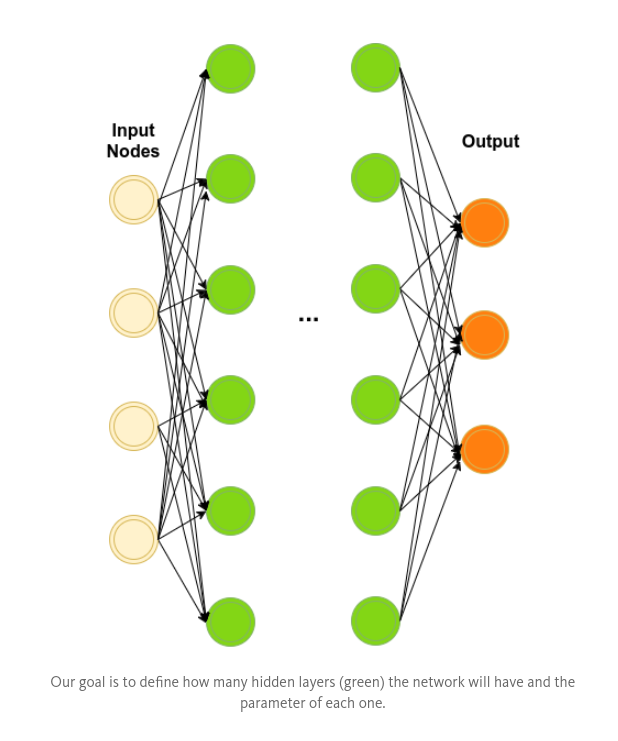

In [2]:
Image('../../images/automl_tuto_0.png')

목표는 주어진 데이터셋으로부터 최적의 성능을 내기 위한 모델의 <strong>architecture와 parameter space</strong>를 찾는 것입니다.  이러한 문제 셋팅은 복잡한데다 보상(rewards)도 sparse합니다. reward가 sparse하다는 것은 네트워크가 충분한 포인트에 도달할 수 있도록 훈련해야 하고 이를 평가해야 한다는 뜻입니다. <i> 훈련-평가 페어(사이클)가 이루어질 때서야 보상이 발생하는데 이게 sparse하다는 뜻인듯</i> 이러한 종류의 보상은 미분가능한 함수가 아닙니다. 뭔가 생각나는가요? 맞아요! 바로 전형적인 <strong>Reinforcement Learning</strong> 시나리오입니다.

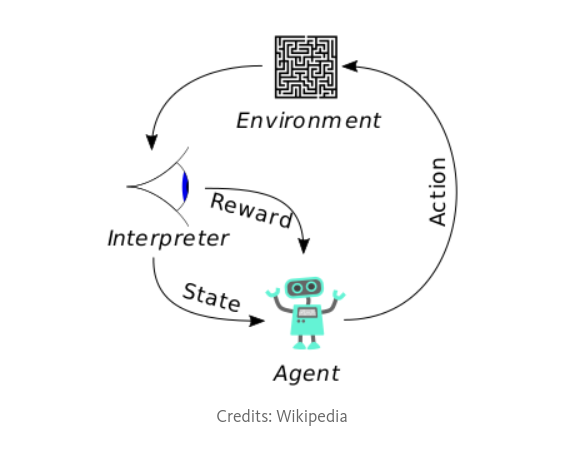

In [3]:
Image('../../images/automl_tuto_1.png')

우리 시나리오의 에이전트는 모델이고 환경은 학습과 평가에 사용하는 데이터셋입니다. Interpreter는 각 에피소드의 reward과 에이전트의 state, 혹은 policy를 분석하는 과정을 말합니다. 

보통 강화학습은 Markov decision process로서 모델링됩니다. 에이전트의 전체 보상을 최대화하는 것이 목적이고 각 스텝마다 당신은 당신이 만든 모델의 결과물을 최적화하고 새로운 액션을 탐색해야 합니다. 

#  Evolutionary algorithms

강하학습 시나리오를 풀어내는 또다른 접근은 바로 <strong>진화 알고리즘</strong>입니다. 생물학적 진화에 영감받아, 진화알고리즘은 population of solutions을 만들어 내며 solution space를 탐색합니다. 그런 다음 각 solution을 평가하고 각 solution의 fitness(score)를 반영하여 진화합니다. 진화는 population 내의 멤버들을 선택(Selection)하거나 변화(Mutation)하는 것을 포함합니다. 결과적으로 population은 자신의 전체 fitness를 증가시키기 위해 진화할 것이고 문제를 풀 수 있는 solutions을 만들어 낼 것입니다.

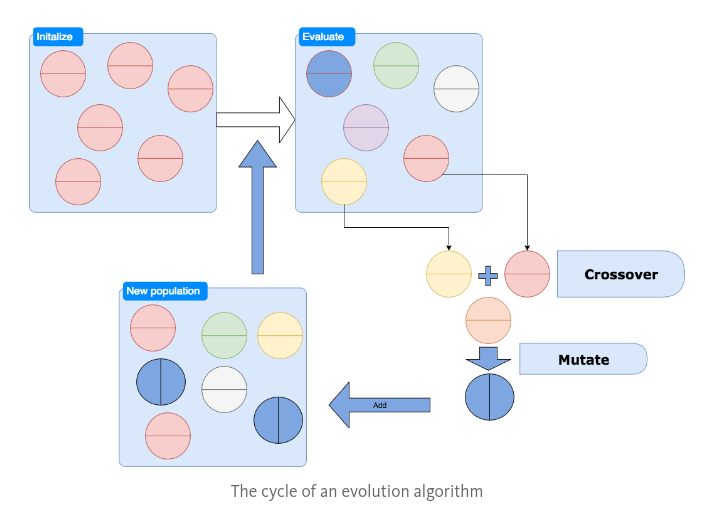

In [4]:
Image('../../images/automl_tuto_2.png')

## Selection 

Parents가 뽑히는 방법이다. 실제로는 k-best를 선택하고 다양성을 위해 약간의 random individuals을 뽑는다. 더 진보한 selection 방법은 population(종종 species로도 언급된다)의 다른 subgroups을 만들어 내고나서 top-k를 선택하는 것이다. 이는 solution space의 다양성을 보존해준다. 또다른 방법은 랜덤으로 참가자를 뽑아 토너먼트 형태로 경쟁시켜서 승자를 뽑는 것이다. (<strong>tournament selection</strong>) (각 개인은 넘겨줄 유전자를 선택한다)

## Crossover 

두명 이상의 부모가 offspring을 만들어 내기 위해 섞이는 과정이다. 이는 문제의 구조에 아주 의존적이다. 가장 일반적인 접근은 각 부모를 elements(usually numerical values)의 리스트로 다루는 것이고 이 중에서 랜덤으로 parts(게놈)를 선택해서 새로운 리스트로 조합해 낸다. 

## Mutation 

게놈을 랜덤으로 대체하는 과정이다. 이는 주요한 탐색과정이며 population의 다양성을 유지하는데 도움을 준다.

# Implementation 

In [5]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from torchvision import datasets, transforms
torch.manual_seed(1)

In [6]:
USE_CUDA = torch.cuda.is_available()

유명한 예제인 MNIST 데이터셋을 이용하여 간단한 분류 테스크를 풀기 위해 DNNs을 탐색해볼 것이다.  DNN 모델의 population을 만들고 그를 N steps만큼 진화시켜보자

앞서 말한 것 중, <strong>tournament selection method</strong>을 사용할 것이다. 수도코드는 아래와 같다. <br><br>

new_population = []<br>
while size(new_population) < population_size:<br>

    choose k(tournament) individuals from the population at random
    choose the best from pool/tournament with probability p1
    choose the second best individual with probability p2
    choose the third best individual with probability p3
    mutate and append selected to the new_population

### Crossover problem 

Crossover는 혼합 구조에서 아주 복잡하다. 어떻게 두 부모의 구조를 합칠 것인가? 어떻게 이것이 훈련과 튜닝 시나리오에 의해 영향을 받을 것인가? 최근에 <a href="https://arxiv.org/pdf/1703.00548.pdf">CoDeepNEAT</a>라는 이름의 아주 멋진 솔루션이 이 문제를 해결했다. 이 아키텍처는 모듈들의 조합이고, 각 모듈은 진화(evolution) 그 자체이다. 또한 그 아키텍처는 컴포넌트들을 결합하기 위한 청사진이다. 부모의 각 컴포넌트가 아주 작은 완전한 네트워크이기 때문에 이러한 컴포넌트들을 섞는 것은 말이 된다. (<i>다음 포스트에서 이러한 기술들에 대해서 좀 더 설명하신다고 함</i>)

## Basic building blocks 

가장 먼저 해야할 일은 각 모델의 솔루션 스페이스를 정의하는 것이다. 각각은 아키텍처를 나타낸다. 간단하게 우리는 n-layers를 쌓을 것이다. 각 layer는 3가지 파라미터가 있다.

1. number of hidden units
2. activation type
3. dropout rate

또한 글로벌한 파라미터들

1. optimizer
2. learning rates
3. weight decay
4. number of layers

In [7]:
# definition of a space
# lower bound - upper bound, type param, mutation rate
LAYER_SPACE = dict()
LAYER_SPACE['nb_units'] = (128, 1024, 'int', 0.15) 
LAYER_SPACE['dropout_rate'] = (0.0, 0.7, 'float', 0.2)
LAYER_SPACE['activation'] =\
    (0,  ['linear', 'tanh', 'relu', 'sigmoid', 'elu'], 'list', 0.2)

NET_SPACE = dict()
NET_SPACE['nb_layers'] = (1, 3, 'int', 0.15)
NET_SPACE['lr'] = (0.0001, 0.1, 'float', 0.15)
NET_SPACE['weight_decay'] = (0.00001, 0.0004, 'float', 0.2)
NET_SPACE['optimizer'] =\
    (0, ['sgd', 'adam', 'adadelta', 'rmsprop'], 'list', 0.2)

그 다음 기본적인 함수들을 만든다.

### * randomise a network

먼저 number of layers와 각 layer의 파라미터들을 랜덤하게 샘플링한다.(<strong>Initialize</strong>) 샘플링된 값은 미리 정의한 구간 내에서 한정된다. 파라미터를 초기화할 때, 우리는 <strong>random parameter id</strong> 역시 생성한다. 당장은 필요없지만 모든 레이어를 추적할 것이다. 새로운 모델이 오래된 레이어를 mutate할 때, mutated된 것만 초기화하여 파인 튜닝하는 것도 가능하다? 이는 스피드도 올리고 솔루션의 안정성도 가져온다. 

In [8]:
def random_value(space):
    """Sample  random value from the given space."""
    val = None
    if space[2] == 'int':
        val = random.randint(space[0], space[1])
    if space[2] == 'list':
        val = random.sample(space[1], 1)[0]
    if space[2] == 'float':
        val = ((space[1] - space[0]) * random.random()) + space[0]
    return {'val': val, 'id': random.randint(0, 2**10)}


def randomize_network(bounded=True):
    """Create a random network."""
    global NET_SPACE, LAYER_SPACE
    net = dict()
    for k in NET_SPACE.keys():
        net[k] = random_value(NET_SPACE[k])
    
    if bounded: 
        net['nb_layers']['val'] = min(net['nb_layers']['val'], 1)
    
    layers = []
    for i in range(net['nb_layers']['val']):
        layer = dict()
        for k in LAYER_SPACE.keys():
            layer[k] = random_value(LAYER_SPACE[k])
        layers.append(layer)
    net['layers'] = layers
    return net



def mutate_net(net):
    """Mutate a network.
    각 네트워크의 요소는 mutation 확률을 할당받는다. 
    각 mutation은 파라미터 스페이스에서 다시 샘플링함으로 파라미터를 바꾼다
    """
    global NET_SPACE, LAYER_SPACE

    # mutate optimizer
    for k in ['lr', 'weight_decay', 'optimizer']:
        
        if random.random() < NET_SPACE[k][-1]: # mutation rate
            net[k] = random_value(NET_SPACE[k])
            
    # mutate layers
    for layer in net['layers']:
        for k in LAYER_SPACE.keys():
            if random.random() < LAYER_SPACE[k][-1]:
                layer[k] = random_value(LAYER_SPACE[k])
    # mutate number of layers -- RANDOMLY ADD
    if random.random() < NET_SPACE['nb_layers'][-1]:
        if net['nb_layers']['val'] < NET_SPACE['nb_layers'][1]:
            if random.random()< 0.5:
                layer = dict()
                for k in LAYER_SPACE.keys():
                    layer[k] = random_value(LAYER_SPACE[k])
                net['layers'].append(layer)
                # value & id update
                net['nb_layers']['val'] = len(net['layers'])
                net['nb_layers']['id'] +=1
            else:
                if net['nb_layers']['val'] > 1:
                    net['layers'].pop()
                    net['nb_layers']['val'] = len(net['layers'])
                    net['nb_layers']['id'] -=1
    return net

##  make the network 

In [9]:
class CustomModel():

    def __init__(self, build_info, CUDA=True):

        previous_units = 28 * 28
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units']['val'])
                )
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate']['val'])
                )
            if layer_info['activation']['val'] == 'tanh':
                self.model.add_module(
                    'tanh_'+i,
                    nn.Tanh()
                )
            if layer_info['activation']['val'] == 'relu':
                self.model.add_module(
                    'relu_'+i,
                    nn.ReLU()
                )
            if layer_info['activation']['val'] == 'sigmoid':
                self.model.add_module(
                    'sigm_'+i,
                    nn.Sigmoid()
                )
            if layer_info['activation']['val'] == 'elu':
                self.model.add_module(
                    'elu_'+i,
                    nn.ELU()
                )
            previous_units = layer_info['nb_units']['val']

        self.model.add_module(
            'classification_layer',
            nn.Linear(previous_units, 10)
            )
        self.model.add_module('sofmax', nn.LogSoftmax())
        self.model.cpu()
        
        if build_info['optimizer']['val'] == 'adam':
            optimizer = optim.Adam(self.model.parameters(),
                                lr=build_info['weight_decay']['val'],
                                weight_decay=build_info['weight_decay']['val'])

        elif build_info['optimizer']['val'] == 'adadelta':
            optimizer = optim.Adadelta(self.model.parameters(),
                                    lr=build_info['weight_decay']['val'],
                                    weight_decay=build_info['weight_decay']['val'])

        elif build_info['optimizer']['val'] == 'rmsprop':
            optimizer = optim.RMSprop(self.model.parameters(),
                                    lr=build_info['weight_decay']['val'],
                                    weight_decay=build_info['weight_decay']['val'])
        else:
            optimizer = optim.SGD(self.model.parameters(),
                                lr=build_info['weight_decay']['val'],
                                weight_decay=build_info['weight_decay']['val'],
                                momentum=0.9)
        self.optimizer = optimizer
        self.cuda = False
        if CUDA:
            self.model.cuda()
            self.cuda = True

위 클래스는 "genome"을 인스터스화할 것이다.

이제 어떻게 네트워크를 랜덤으로 생성하고, 그 구조를 변형하고 훈련시킬 것인지 알았다. 그 다음은 최고 성능을 내는 컴포넌트들을 선택하고 변형하는 genetic algorithm을 만드는 것이다. 각 모델은 병렬로 훈련되고 각 에이전트 간의 정보 교환을 요구하지도 않는다. 이는 리니어한 시간만에 최적화 프로세스를 할 수 있게 만든다. 

In [10]:
import random
import numpy as np
from operator import itemgetter
import torch.multiprocessing as mp
import net_builder
import copy
from worker import CustomWorker, Scheduler

In [11]:
class TournamentOptimizer:
    """Define a tournament play selection process."""

    def __init__(self, population_sz, init_fn, mutate_fn, nb_workers=2, use_cuda=True):
        """
        Initialize optimizer.
            params::
                
                init_fn: initialize a model
                mutate_fn: mutate function - mutates a model
                nb_workers: number of workers
        """
        
        self.init_fn = init_fn
        self.mutate_fn = mutate_fn
        self.nb_workers = nb_workers
        self.use_cuda = use_cuda
        
        # population
        self.population_sz = population_sz
        self.population = [init_fn() for i in range(population_sz)]        
        self.evaluations = np.zeros(population_sz)
        
        # book keeping
        self.elite = []
        self.stats = []
        self.history = []

    def step(self):
        """Tournament evolution step."""
        print('\nPopulation sample:')
        for i in range(0,self.population_sz,2):
            print(self.population[i]['nb_layers'],
                  self.population[i]['layers'][0]['nb_units'])
        self.evaluate()
        children = []
        print('\nPopulation mean:{} max:{}'.format(
            np.mean(self.evaluations), np.max(self.evaluations)))
        n_elite = 2
        sorted_pop = np.argsort(self.evaluations)[::-1]
        elite = sorted_pop[:n_elite]
        
        # print top@n_elite scores
        # elites always included in the next population
        self.elite = []
        print('\nTop performers:')
        for i,e in enumerate(elite):
            self.elite.append((self.evaluations[e], self.population[e]))    
            print("{}-score:{}".format( str(i), self.evaluations[e]))   
            children.append(self.population[e])
        # tournament probabilities:
        # first p
        # second p*(1-p)
        # third p*((1-p)^2)
        # etc...
        p = 0.85 # winner probability 
        tournament_size = 3
        probs = [p*((1-p)**i) for i in range(tournament_size-1)]
        # a little trick to certify that probs is adding up to 1.0
        probs.append(1-np.sum(probs))
        
        while len(children) < self.population_sz:
            pop = range(len(self.population))
            sel_k = random.sample(pop, k=tournament_size)
            fitness_k = list(np.array(self.evaluations)[sel_k])
            selected = zip(sel_k, fitness_k)
            rank = sorted(selected, key=itemgetter(1), reverse=True)
            pick = np.random.choice(tournament_size, size=1, p=probs)[0]
            best = rank[pick][0]
            model = self.mutate_fn(self.population[best])
            children.append(model)

        self.population = children
        
        # if we want to do a completely completely random search per epoch
        # self.population = [randomize_network(bounded=False) for i in range(self.population_sz) ]

    def evaluate(self):
        """evaluate the models."""
        
        workerids = range(self.nb_workers)
        workerpool = Scheduler(workerids, self.use_cuda )
        self.population, returns = workerpool.start(self.population)

        self.evaluations = returns
        self.stats.append(copy.deepcopy(returns))
        self.history.append(copy.deepcopy(self.population))

# Run

In [12]:
import pickle

In [13]:
CUDA_ = USE_CUDA

In [14]:
nb_evolution_steps = 10
tournament = TournamentOptimizer(
            population_sz=50,
            init_fn=net_builder.randomize_network,
            mutate_fn=net_builder.mutate_net,
            nb_workers=3,
            use_cuda=True)

for i in range(nb_evolution_steps):
    print('\nEvolution step:{}'.format(i))
    print('================')
    tournament.step()
    # keep track of the experiment results & corresponding architectures
    name = "tourney_{}".format(i)
    pickle.dump(tournament.stats, open(name + '.stats','wb'))
    pickle.dump(tournament.history, open(name +'.pop','wb'))


Evolution step:0

Population sample:
{'val': 1, 'id': 225} {'val': 838, 'id': 179}
{'val': 1, 'id': 100} {'val': 494, 'id': 980}
{'val': 1, 'id': 337} {'val': 237, 'id': 573}
{'val': 1, 'id': 830} {'val': 291, 'id': 598}
{'val': 1, 'id': 897} {'val': 948, 'id': 393}
{'val': 1, 'id': 516} {'val': 503, 'id': 645}
{'val': 1, 'id': 588} {'val': 977, 'id': 245}
{'val': 1, 'id': 404} {'val': 716, 'id': 791}
{'val': 1, 'id': 47} {'val': 598, 'id': 361}
{'val': 1, 'id': 790} {'val': 756, 'id': 604}
{'val': 1, 'id': 877} {'val': 196, 'id': 315}
{'val': 1, 'id': 828} {'val': 977, 'id': 824}
{'val': 1, 'id': 973} {'val': 1020, 'id': 156}
{'val': 1, 'id': 370} {'val': 851, 'id': 1005}
{'val': 1, 'id': 761} {'val': 168, 'id': 958}
{'val': 1, 'id': 188} {'val': 559, 'id': 642}
{'val': 1, 'id': 284} {'val': 485, 'id': 264}
{'val': 1, 'id': 797} {'val': 711, 'id': 702}
{'val': 1, 'id': 701} {'val': 763, 'id': 39}
{'val': 1, 'id': 233} {'val': 720, 'id': 664}
{'val': 1, 'id': 809} {'val': 653, 'id': 1

Process ModelProcessor:
Process ModelProcessor:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ModelProcessor:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/dsksd/work/PT_dsksd/evolutionary_algorithms/worker.py", line 86, in run
    xnet  = torch_models.CustomModel(net, self.use_cuda)
Traceback (most recent call last):
  File "/home/dsksd/work/PT_dsksd/evolutionary_algorithms/worker.py", line 86, in run
    xnet  = torch_models.CustomModel(net, self.use_cuda)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/dsksd/.local/lib/python3.5/site-packages/torch/nn/modules/module.py", line 147, in cuda
    return self._apply(lambda t: t.cuda(device_id))
  File "/home/dsksd/work/PT_dsksd/evolutionary_algorithms/torch_models.py", line 91, in __init__
 

All workers are done


KeyboardInterrupt: 